# Moving Box - Encoder Decoder

In [259]:
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from util.tf_ops import *

from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Collect an ensemble of box data

In [274]:
img_collections = get_processed_moving_box_squares(augment=True)
img_collections += get_processed_diamond(augment=True)
img_collections += get_processed_rectangle(augment=True)
img_collections += get_processed_cirlce(augment=True)

img_collections = center_collections(img_collections)
# number of images for each collection
num_per_collection = [x.shape[0] for x in img_collections]
# number of collections
n_collection = len(img_collections)
# total number of images
total_imgs = sum(num_per_collection)
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(n_collection, total_imgs))

{'dim': (56, 32, 32), 'images:': 'bigsquare-vertical-4'}
{'dim': (56, 32, 32), 'images:': 'bigSquare-vertical-2'}
{'dim': (56, 32, 32), 'images:': 'square-diagnal-2'}
{'dim': (56, 32, 32), 'images:': 'square-vertical-4'}
{'dim': (56, 32, 32), 'images:': 'bigSquare-vertical'}
{'dim': (56, 32, 32), 'images:': 'bigSquare-diagnal-2'}
{'dim': (56, 32, 32), 'images:': 'square-vertical-2'}
{'dim': (56, 32, 32), 'images:': 'square-vertical-5'}
{'dim': (56, 32, 32), 'images:': 'square-vertical-3'}
{'dim': (56, 32, 32), 'images:': 'bigSquare-vertical-3'}
{'dim': (56, 32, 32), 'images:': 'bigSquare-diagnal'}
{'dim': (56, 32, 32), 'images:': 'bigsquare-vertical-5'}
{'dim': (56, 32, 32), 'images:': 'square-diagnal'}
{'dim': (7, 32, 32), 'images:': 'background'}
{'dim': (56, 32, 32), 'images:': 'diamond'}
{'dim': (56, 32, 32), 'images:': 'big-diamond-vertical'}
{'dim': (56, 32, 32), 'images:': 'diamond-vertical3'}
{'dim': (56, 32, 32), 'images:': 'big-diamond-diagnal1'}
{'dim': (56, 32, 32), 'images

In [275]:
test_file = "data/moving-box/processed/Box/test/square-vertical.npz"
test_imgs = load_imgs(test_file)

{'dim': (56, 32, 32), 'images:': 'square-vertical'}


## Sample Train and Dev

In [276]:
def sample(batch_size = 8, train=True, gap = 1):
    train_ind_collection, val_ind_collection = zip(*[split_train_dev(x) for x in img_collections])
          
    # get average number of training for each class
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # before-index for each class
    before_ind = []
    for i in range(n_collection):
        data = train_ind_collection[i] if train else val_ind_collection[i]
        try:
            s = np.random.choice(list(filter(lambda x:x<num_per_collection[i]-gap-1, data)),avg_num_per_class, replace=False)
            before_ind.append(s)
        except:
            before_ind.append(np.array([]))
    # after-index for each class
    after_ind = [x+gap+1 for x in before_ind]
    # mid-index for each class
    mid_ind = [x+(gap+1)//2 for x in before_ind]
    
    selected_classed = [i for i in range(n_collection) if before_ind[i].shape[0]>0]
    before_imgs = np.concatenate([img_collections[i][before_ind[i]] for i in selected_classed], axis = 0)
    after_imgs = np.concatenate([img_collections[i][after_ind[i]] for i in selected_classed], axis = 0)
    mid_imgs = np.concatenate([img_collections[i][mid_ind[i]] for i in selected_classed], axis = 0)
    
    clipped = np.random.choice(range(before_imgs.shape[0]), batch_size, replace=False)
    before_imgs = before_imgs[clipped]
    mid_imgs = mid_imgs[clipped]
    after_imgs = after_imgs[clipped]
    return before_imgs, after_imgs, mid_imgs


def sample_train(batch_size = 8, gap = 1): return sample(batch_size, True, gap = gap)

def sample_dev(batch_size = 8, gap = 1):  return sample(batch_size, False, gap)

## Sample Test

In [277]:
def sample_test(batch_size = 8, gap = 1):  
    return sample_pred_frames(test_imgs, gap, batch_size)

## Take a look at Training data

Range of Image Piece Value: [-1.0, 3.0]
Before: (8, 32, 32)
After:  (8, 32, 32)
Mid:    (8, 32, 32)


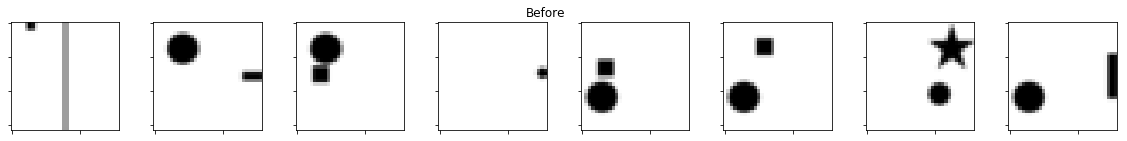

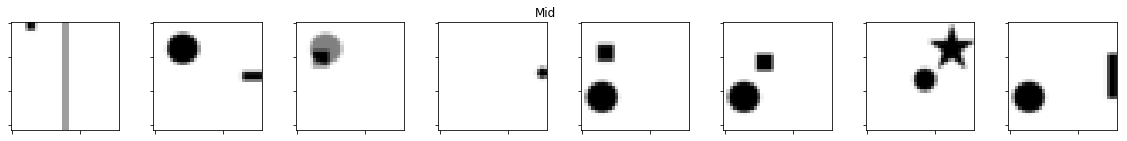

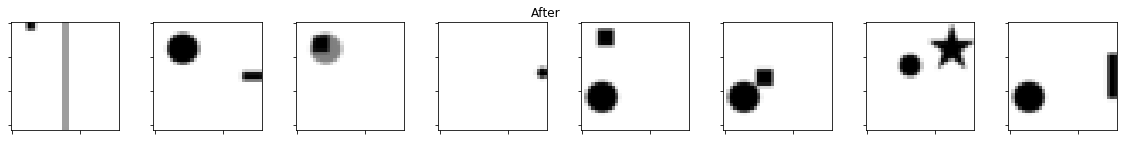

In [281]:
test_before, test_after, test_mid = sample_train(batch_size=8, gap=9)
print("Range of Image Piece Value: [{}, {}]".format(np.min(test_mid), np.max(test_mid)))
print("Before: {}".format(test_before.shape))
print("After:  {}".format(test_after.shape))
print("Mid:    {}".format(test_mid.shape))
size = (20, 2)
plot_images(test_before, size, "Before")
plot_images(test_mid, size, "Mid")
plot_images(test_after, size, "After")

## Sample of Test Data

Before: (8, 32, 32)
After:  (8, 32, 32)
Mid:    (8, 32, 32)


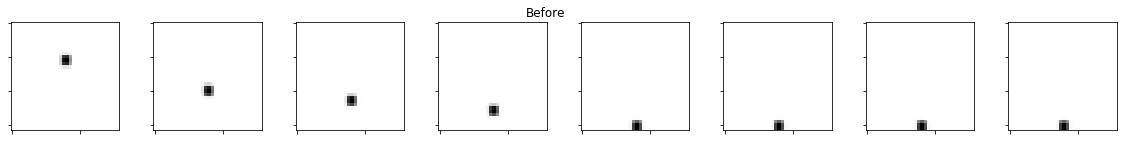

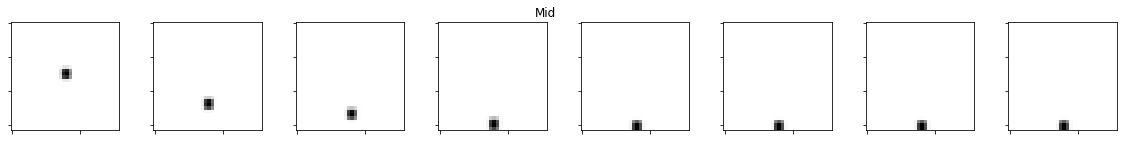

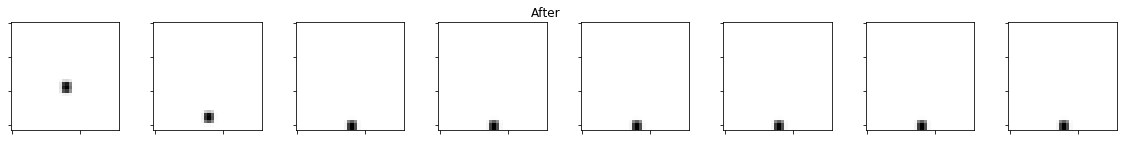

In [282]:
before, after, mid = sample_test(batch_size=8, gap=7)
print("Before: {}".format(test_before.shape))
print("After:  {}".format(test_after.shape))
print("Mid:    {}".format(test_mid.shape))
size = (20, 2)
plot_images(before, size, "Before")
plot_images(mid, size, "Mid")
plot_images(after, size, "After")

## Target

### Gap: How harsh do you want to train the model?

In [309]:
gap = 5

### Model Capacity

In [310]:
feature_channel = 128
dense_size = 128

## Param

In [311]:
batch_size = 64

learning_rate = 1e-4

beta = 0.9 # defalut 0.9 for adam
num_iteration = 8000
relu_alpha = 0.01

# Encoder

In [320]:
def encode(img, is_training=True):
    """
    Input:
        batch size of img
    Output:
        batch size of feature [batch_size, 8 x 8 x feature_channel]
    """
    x = tf.reshape(img, [-1, 32, 32, 1])
    x = tf.layers.conv2d(x, filters = 4, kernel_size=6, strides=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, axis=3, training=is_training)

    x = tf.layers.conv2d(x, filters = 8, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, axis=3, training=is_training)

    x = tf.layers.conv2d(x, filters = 16, kernel_size=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, axis=3, training=is_training)
    
    x = tf.layers.conv2d(x, filters = feature_channel, kernel_size=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, axis=3, training=is_training)
    x = tf.contrib.layers.flatten(x)
    return x

# Decoder

In [321]:
def decode(feature1, feature2, is_training=True):
    """
    Input:
        batch size of feature [batch_size, 8 x 8 x feature_channel]
    Output:
        batch size of img [batch_size, 32, 32, 1]
    """

    x = (feature1 + feature2)/2

    x = tf.layers.dense(x, 8*8*dense_size, activation=tf.nn.relu)
    x = tf.reshape(x, [-1, 8, 8, dense_size])
    
    x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, axis=3, training=is_training)
    
    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=4, strides=(2, 2), activation=tf.nn.relu, padding='same')
    x = tf.layers.batch_normalization(x,  axis=3, training=is_training)

    img = tf.layers.conv2d_transpose(x, filters=1, kernel_size=6,  strides=(2, 2), activation=tf.nn.tanh, padding='same')
    img = tf.reshape(img, [-1, 32, 32, 1])
    return img

## Generator

In [322]:
def generate(x1, x2,  is_training=True):
    with tf.variable_scope("generator") as scope:
        feature1, feature2 = encode(x1, is_training), encode(x2, is_training)
        img = decode(feature1, feature2, is_training)
        return img

### Loss

In [323]:
def content_loss(x, gd):
    x, gd = tf.contrib.layers.flatten(x), tf.contrib.layers.flatten(gd)
    return tf.norm(x-gd)

### Get a Batch Generation

In [324]:
def get_generattion(before, after, mid):
    dic = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False}
    gen_batch = sess.run(G_batch, dic)
    return gen_batch

### Solver

In [325]:
def get_solver(learning_rate=1e-3, beta1=0.5):
    return tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

### Report Loss = loss_computed * 255 / batch_size

In [326]:
def report_loss(name, num_run = 100, gap = 3, batch_size = batch_size):
    losses = []
    for _ in range(num_run):
        if name == "train": before, after, mid = sample_train(batch_size, gap)
        elif name == "val": before, after, mid = sample_dev(batch_size, gap)
        else:                before, after, mid = sample_test(batch_size, gap) 
        loss = sess.run(G_loss, \
                        feed_dict = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False})
        losses.append(loss)
    return scale_loss(np.mean(losses) / batch_size, 2)

## Computational Graph

In [327]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 32, 32])
batch_before     = tf.placeholder(tf.float32, [None, 32, 32])
batch_after      = tf.placeholder(tf.float32, [None, 32, 32])
is_training      = tf.placeholder(tf.bool, ())

G_batch = generate(batch_before, batch_after)

G_loss = content_loss(G_batch, batch_mid)
G_solver = get_solver(learning_rate, beta)

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

In [328]:
def train(sess, G_step, G_loss, batch_size, num_iteration, plot_every = 400, show_loss_every=400, nPlot=6):
    g_losses = []
    g_losses_test = []
    for i in range(num_iteration):
        # get a sample
        real_before, real_after, real_mid = sample_train(batch_size, gap)
        dic = {batch_mid: real_mid, batch_before: real_before, batch_after: real_after, is_training: True}
        
        _, G_loss_curr = sess.run([G_train_step, G_loss], dic)
        G_loss_curr = scale_loss(G_loss_curr/batch_size, 2)# tweek loss to match report loss
        
        g_losses.append(G_loss_curr)
        
        test_before, test_after, test_mid = sample_test(8, gap)
        test_loss = sess.run(G_loss, {batch_mid: test_mid, batch_before: test_before, batch_after: test_after, is_training: False})
        g_losses_test.append(scale_loss(test_loss, 2))
    
        if i%show_loss_every ==0:
            print("Iteration {}:  G_loss = {}".format(i, G_loss_curr))
            
        if i%plot_every == 0:
            gen_batch_test = sess.run(G_batch, feed_dict=\
                                      {batch_before: real_before, batch_after: real_after, is_training: False})
            plot_batch_images(gen_batch_test[:nPlot], (16, 2) , "Iteration: {}".format(i))
            
            
            gen_batch_test = sess.run(G_batch, feed_dict=\
                                      {batch_before: test_before, batch_after: test_after, is_training: False})
            plot_batch_images(gen_batch_test[:nPlot], (16, 2) , "Iteration: {} on Test Images".format(i))
            
    return g_losses, g_losses_test

# Train !

Iteration 0:  G_loss = 1443.6562299728394


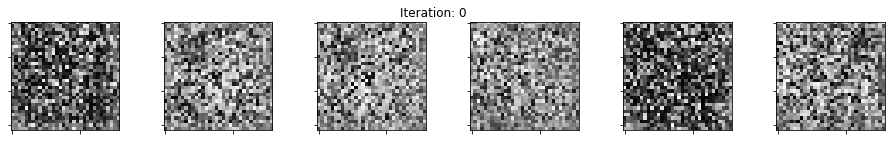

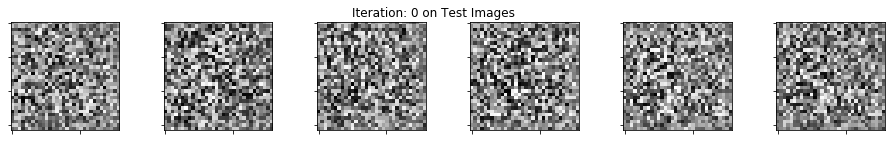

Iteration 200:  G_loss = 1031.5111327171326
Iteration 400:  G_loss = 1009.9558317661285
Iteration 600:  G_loss = 987.4524056911469
Iteration 800:  G_loss = 987.9698467254639


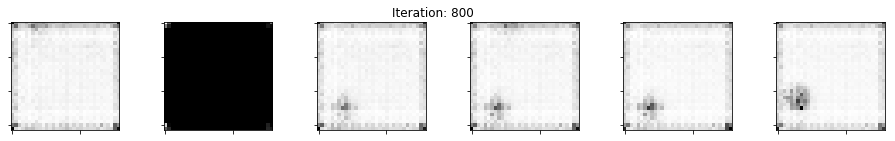

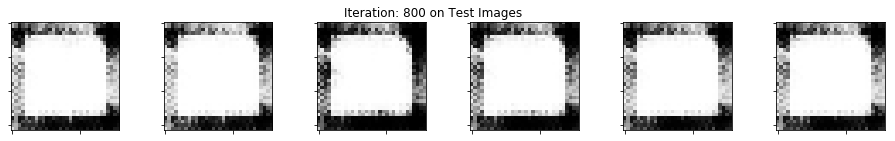

Iteration 1000:  G_loss = 983.4442591667175
Iteration 1200:  G_loss = 982.579060792923
Iteration 1400:  G_loss = 984.0064465999603
Iteration 1600:  G_loss = 982.5056183338165


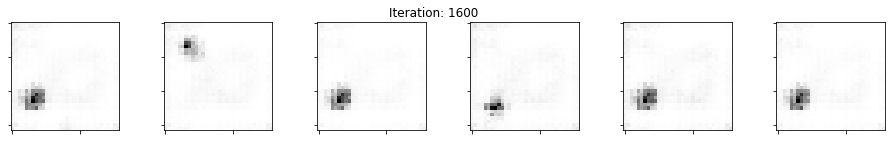

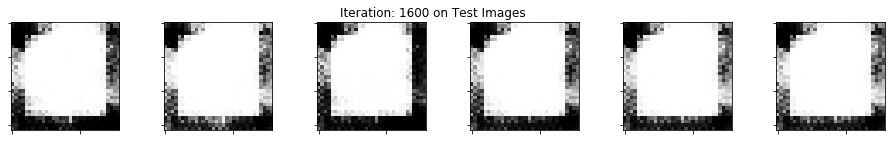

Iteration 1800:  G_loss = 980.7990539073944
Iteration 2000:  G_loss = 981.5192520618439
Iteration 2200:  G_loss = 982.9147803783417
Iteration 2400:  G_loss = 987.492470741272


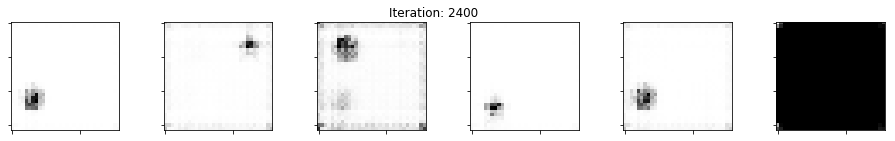

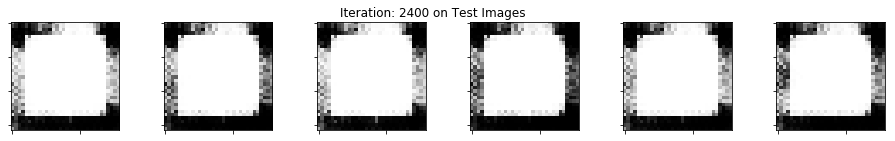

Iteration 2600:  G_loss = 982.4361884593964
Iteration 2800:  G_loss = 983.7005174160004
Iteration 3000:  G_loss = 982.9054176807404
Iteration 3200:  G_loss = 980.6445693969727


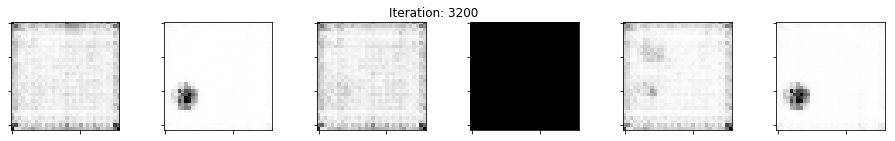

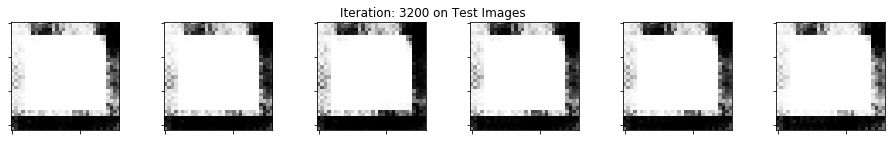

Iteration 3400:  G_loss = 985.9429442882538
Iteration 3600:  G_loss = 983.7186348438263
Iteration 3800:  G_loss = 981.0774421691895
Iteration 4000:  G_loss = 984.2744386196136


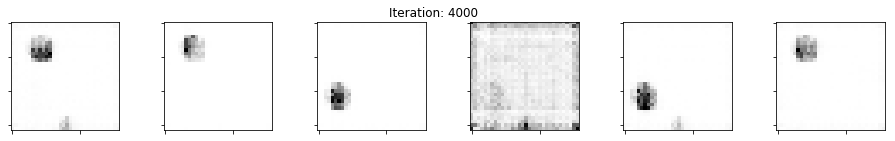

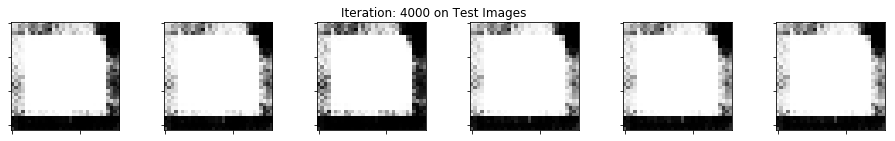

Iteration 4200:  G_loss = 989.5622956752777
Iteration 4400:  G_loss = 980.6708943843842


KeyboardInterrupt: 

In [329]:
sess = get_session()
sess.run(tf.global_variables_initializer())
g_loss, g_losses_test = train(sess, G_train_step, G_loss, batch_size, num_iteration, plot_every = 800, show_loss_every = 200)

## Plot of Learning Curve

In [ ]:
figsize = (20, 8)

plt.figure(figsize=figsize)
plt.plot(g_loss)
plt.title("Generator Losses", fontsize=16)
plt.show()

plt.figure(figsize=figsize)
plt.plot(g_loss[-1000:])
plt.title("Generator Losses - Last 1000", fontsize=16)
plt.show()

plt.figure(figsize=figsize)
plt.plot(g_losses_test)
plt.title("Generator Test Losses", fontsize=16)
plt.show()

plt.figure(figsize=figsize)
plt.plot(g_losses_test[-500:])
plt.title("Generator Test Losses - Last 1000", fontsize=16)
plt.show()

# Evaluate !

In [ ]:
def show_generations(name, num = 6, gap = 3):
    if name == "train":  before, after, mid = sample_train(num, gap)
    elif name == "val":  before, after, mid = sample_dev(num, gap)
    else:                before, after, mid = sample_test(num, gap) 
    
    gen_batch = get_generattion(before, after, mid)
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(after, size, "After")
    plot_images(mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")

## - Evaluate on Training Data

In [ ]:
def eval_train(num_show = 8, gap = 3):
    show_generations("train", num_show, gap)
    loss = report_loss("train", 100, gap, batch_size)
    print("Training Loss = {}".format(loss))
    return loss

train_loss = eval_train(num_show = 8, gap = gap)

## - Evaluate on Validation Data

In [ ]:
def eval_val(num_show = 4, gap = 1, num_test = 100):
    show_generations("val", num_show, gap)
    loss = report_loss("val", 100, gap, batch_size)
    print("Validation Loss = {}".format(loss))

eval_val(num_show = 8, gap = gap)

## - Evaluate on Test Data

In [ ]:
def eval_test(num_show = 6, gap = 3, num_test = 100, batch_size = batch_size):
    show_generations("test", num_show, gap)
    loss = report_loss("test", num_test, gap, batch_size)
    print("Test Loss = {}".format(loss))
    return loss

test_loss = eval_test(num_show = 8, gap=gap, batch_size = 8)

## How much overfitting?

In [ ]:
print("(Test Loss - Train Loss)/Train Loss = {}".format((test_loss-train_loss)/train_loss))